# Тестовое задание
Руководство компании обратило внимание на то, что сотрудники старше 35 
лет болеют чаще, чем более молодые сотрудники. Кроме этого, среди мужчин 
количество пропусков рабочих дней в связи с больничным выше, чем среди женщин. 
В связи с этой ситуацией, руководство организации планирует ввести 
дополнительные медицинские осмотры среди групп риска. 
Вам необходимо проверить следующие гипотезы:
1) Мужчины пропускают в течение года более 2 рабочих дней (work_days) по 
болезни значимо чаще женщин.
2) Работники старше 35 лет (age) пропускают в течение года более 2 рабочих 
дней (work_days) по болезни значимо чаще своих более молодых коллег

## Знакомство с данными

Установим нужные для работы библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.stats.proportion import proportions_ztest

Загрузим файл и построчно обработаем ее, сохранив полученный датафрейм в **df**

In [2]:
# Путь к файлу
file_path = 'М.Тех_Данные_к_ТЗ_DS.csv'

# Чтение всего файла как одной строки
with open(file_path, 'r', encoding='windows-1251') as file:
    content = file.read()

# Разделение содержимого на строки
lines = content.split('\n')

# Обработка каждой строки
processed_data = []
for line in lines:
    if line:  # Проверка, что строка не пустая
        # Удаление кавычек в начале и в конце, разделение по '","'
        parts = line.strip('"').split('","')
        # Дальнейшее разделение первой части по запятой
        processed_data.append(parts[0].split(',') + parts[1:])

# Создание DataFrame из обработанных данных
df_processed = pd.DataFrame(processed_data, columns=['Количество больничных дней', 'Возраст', 'Пол'])

# Удаление лишних кавычек в столбцах 'Возраст' и 'Пол'
df_processed['Возраст'] = df_processed['Возраст'].str.replace('""', '')
df_processed['Пол'] = df_processed['Пол'].str.replace('""', '')

# Удаление первой строки с заголовками
df = df_processed.drop(0)
df.reset_index(drop=True, inplace=True)

Выведем первые 5 строк датафрейма

In [3]:
df.head(5)

,Количество больничных дней,Возраст,Пол
0,5,39,Ж
1,4,54,М
2,4,26,М
3,5,42,М
4,4,29,М


Данные успешно загруженны, изменим названия колонок:
* Количество больничных дней -> count_sick_days
* Возраст -> age
* Пол -> gender

После изменения выведем названия столбцов чтобы убидиться что они изменились

In [4]:
df.columns = ['count_sick_days', 'age', 'gender']
df.columns

Index(['count_sick_days', 'age', 'gender'], dtype='object')

Названия колонок изменены, посмотрим на общую информацию о датафрейме

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   count_sick_days  237 non-null    object
 1   age              237 non-null    object
 2   gender           237 non-null    object
dtypes: object(3)
memory usage: 5.7+ KB


Изменим типы данных в столбцах количество больничных дней и возраст

In [6]:
df['count_sick_days'] = df['count_sick_days'].astype('int64')
df['age'] = df['age'].astype('int64')

Посмотрим на статистику по столбцам **count_sick_days**, **age**

In [7]:
df.describe()

,count_sick_days,age
count,237.000000,237.000000
mean,3.257384,40.181435
std,1.807821,6.875157
min,0.000000,23.000000
25%,2.000000,36.000000
50%,3.000000,41.000000
75%,4.000000,45.000000
max,8.000000,60.000000


## Иследовательский анализ

### Посмотрим распределение данных

Посмтроим гистограмму распределения

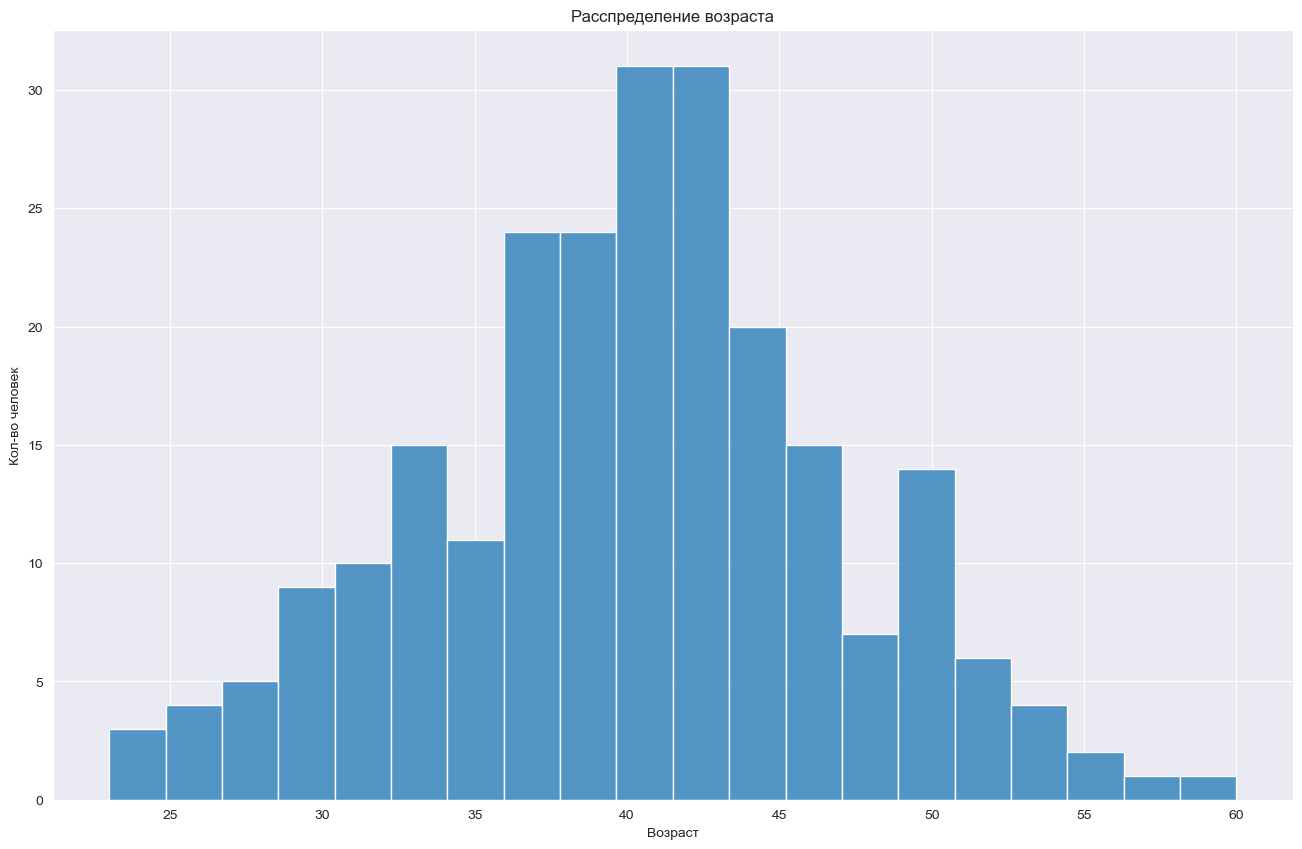

In [8]:
plt.figure(figsize=(16,10))
sns.histplot(df['age'], bins=20).set(xlabel='Возраст',
                                     ylabel='Кол-во человек',
                                     title='Расспределение возраста');

Распределение похоже на нормальное, в компании основной массе рабочих 32-50 лет 

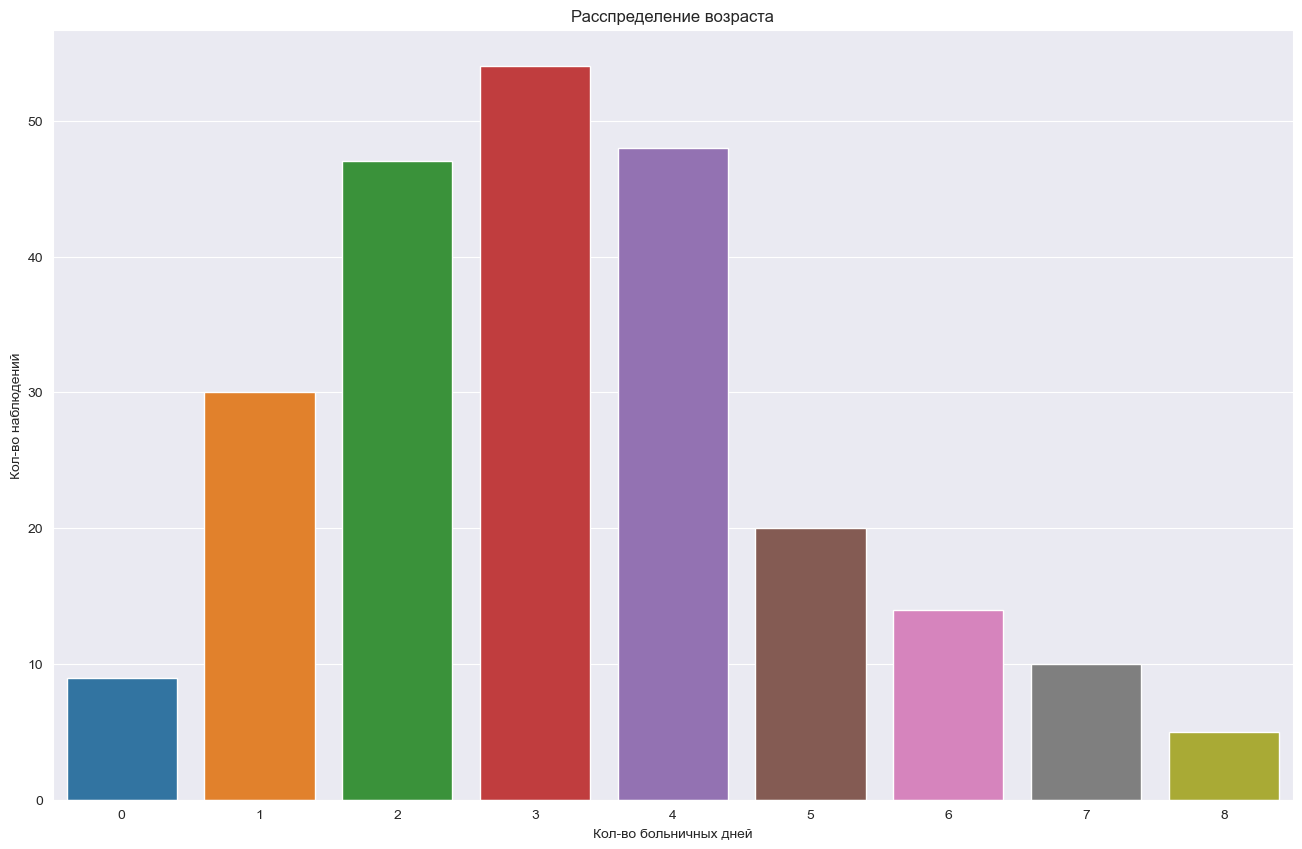

In [9]:
plt.figure(figsize=(16,10))
sns.countplot(df, x='count_sick_days').set(xlabel='Кол-во больничных дней',
                                           ylabel='Кол-во наблюдений',
                                           title='Расспределение возраста');

Распределение похоже на нормальное распределение смещенное в право

Посмотрим на соотношение женщин и мужчин в предоставленных нам данных

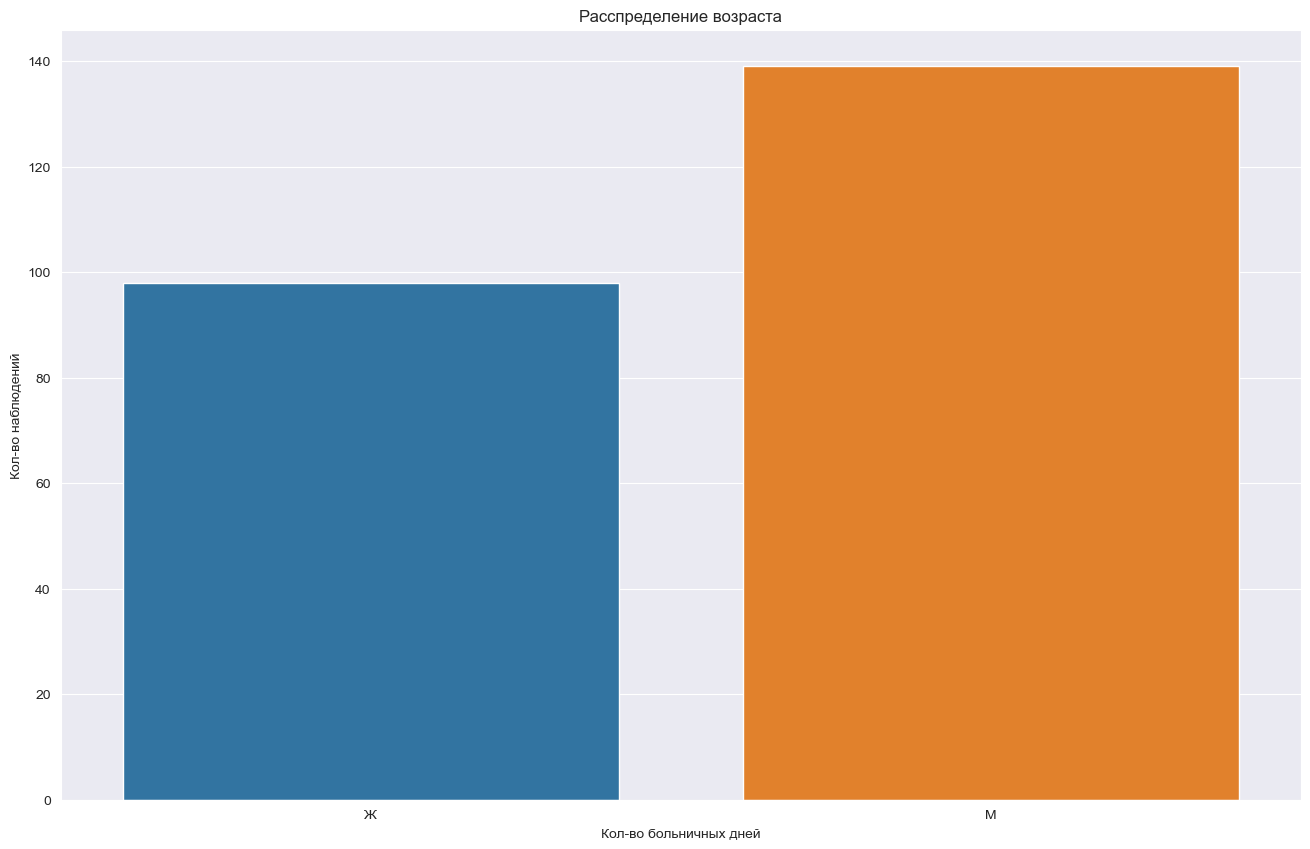

In [10]:
plt.figure(figsize=(16,10))
sns.countplot(df, x='gender').set(xlabel='Кол-во больничных дней',
                                  ylabel='Кол-во наблюдений',
                                  title='Расспределение возраста');

Как мы видим мужчин работает больше в компании чем женщин

### Проверим наблюдение руководства компании

Руководство компании обратило внимание на то, что сотрудники старше 35 лет болеют чаще, чем более молодые сотрудники. Создадим новый bool-признак **older**
* Значение в **older** равно 1, если возраст человека больше 35
* Значение в **older** равно 0, если возраст человека меньше или равен 35

Выведем первые 5 строк датафрейма

In [11]:
df.loc[df['age'] > 35, 'older'] = 1
df.loc[df['age'] <= 35, 'older'] = 0
df.head(5)

,count_sick_days,age,gender,older
0,5,39,Ж,1.0
1,4,54,М,1.0
2,4,26,М,0.0
3,5,42,М,1.0
4,4,29,М,0.0


Посмотрим на соотношение классов в older

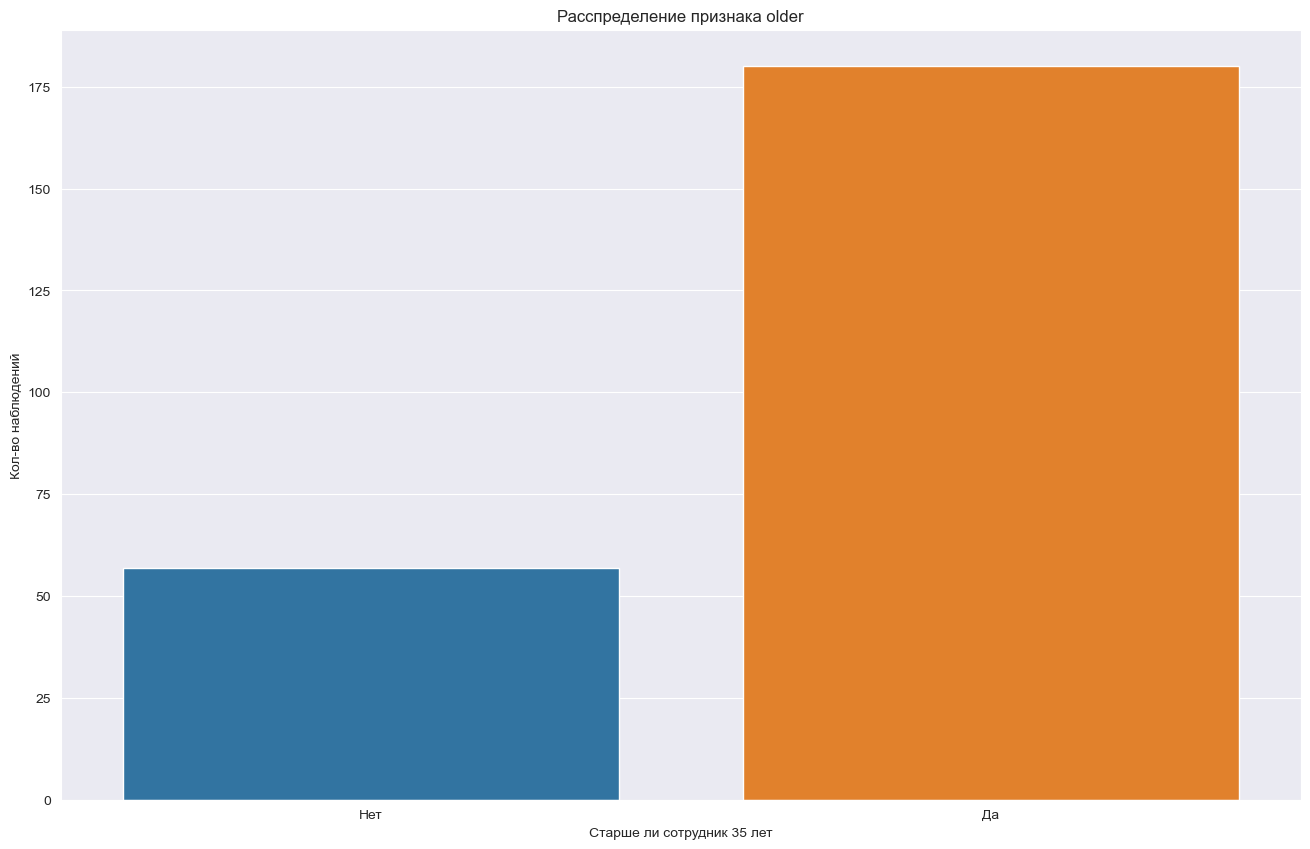

In [12]:
plt.figure(figsize=(16,10))
sns.countplot(df, x='older').set(xlabel='Старше ли сотрудник 35 лет',
                                 ylabel='Кол-во наблюдений',
                                 title='Расспределение признака older',
                                 xticklabels=(['Нет', 'Да']));


Выше мы поняли что средний возраст рабочих 32-50 лет, так что не удивительно что большинству сотрудников больше 35 лет

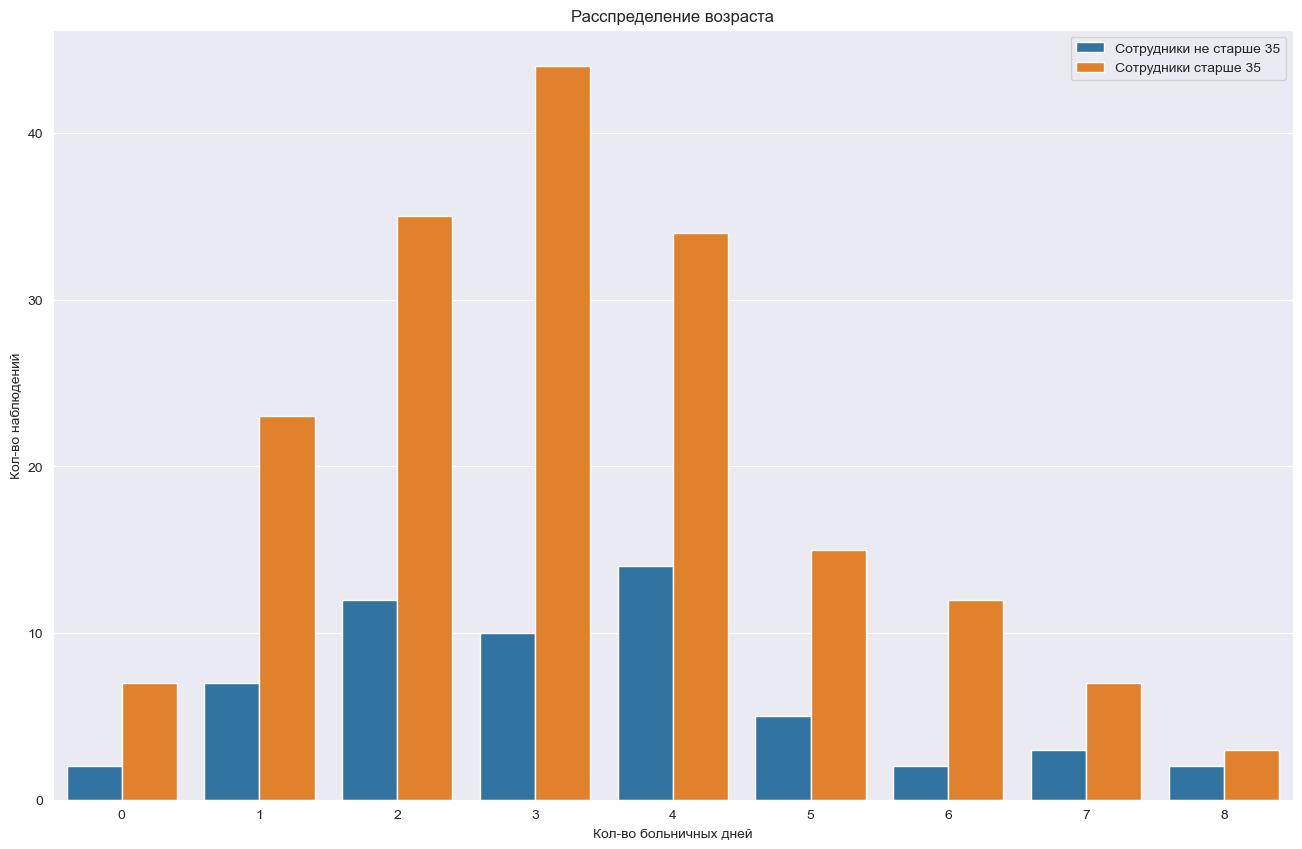

In [13]:
plt.figure(figsize=(16,10))
sns.countplot(df, x='count_sick_days', hue='older').set(xlabel='Кол-во больничных дней',
                                           ylabel='Кол-во наблюдений',
                                           title='Расспределение возраста');
plt.legend(['Сотрудники не старше 35', 'Сотрудники старше 35']);

Как мы видим у сотрудников похожее распределение, чаще всего кол-во больничных дней находиться в диапазоне 1-4 дней, но так же можно заметить что молодые сотрудники чаще в соотношении с более взрослыми сотрудниками, берут длинные больничные 7-8 дней, хотя в то же время стоит подметить, что у нас мало данных о сотрудниках которые болеют 7 и больше дней и в общем у нас в 3 раза меньше данных о сотрудниках которым не больше 35-ти лет

Посмотрим больше ли у мужчин пропусков рабочих дней в связи с больничным, чем у женщин. 

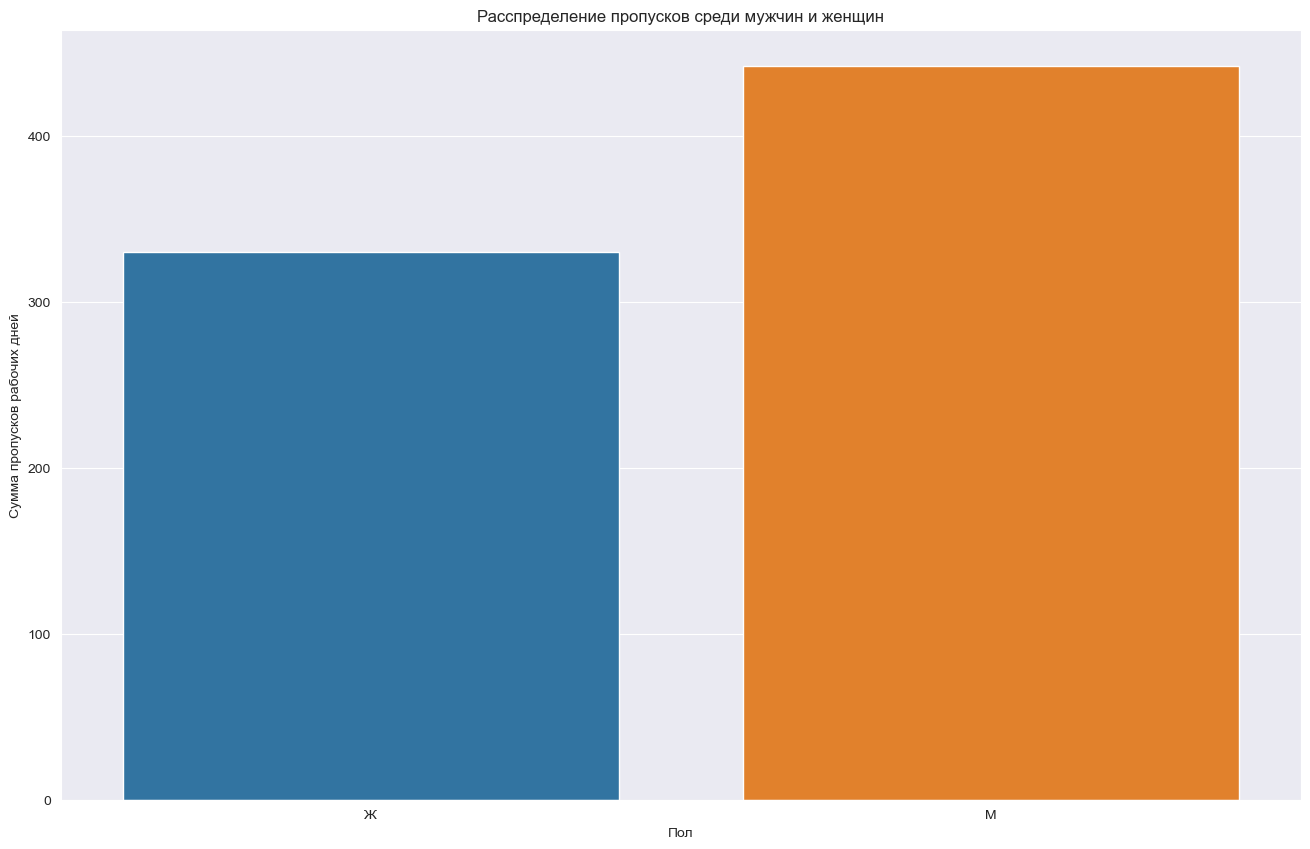

In [14]:
pivot_table = df.pivot_table(index='gender', values='count_sick_days', aggfunc='sum').reset_index()

plt.figure(figsize=(16,10))
sns.barplot(data=pivot_table,
            x='gender',
            y='count_sick_days').set(xlabel='Пол',
                                     ylabel='Сумма пропусков рабочих дней',
                                     title='Расспределение пропусков среди мужчин и женщин');

У мужчин больше пропущенных дней по больничному чем у женщин, но надо помнить, что мужчин в нашем наборе данных чуть больше чем женщин

## Проверка гипотез 

### Гендерные различия в пропусках рабочих дней

Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин
* $H_0$: Нет статистически значимых различий в долях мужчин и женщин, пропускающих более 2 рабочих дней в году. 
* $H_1$: Есть статистически значимые различия в долях мужчин и женщин, пропускающих более 2 рабочих дней в году.

Напишем функцию которая будет принимать в себя датафрейм и количество дней которые пропустил сотрудник, по ним проводить тест и писать полученное в ходе теста p-value и опровергать или не опровергать нулевую гипотезу

In [15]:
def gender_ztest(data, work_days, alpha=0.05):
    df['more_than_2_days'] = df['count_sick_days'] > work_days
    
    count_gender = df.groupby('gender')['more_than_2_days'].sum()
    nobs_gender = df['gender'].value_counts()

    stat_gender, p_value =  proportions_ztest(count_gender, nobs_gender)
    print('p-value:', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотизу')
    else:
        print('Не отвергаем нулевую гипотезу')

Проверим наши гипотезы

In [16]:
gender_ztest(df, 2)

p-value: 3.3236510523985083e-09
Отвергаем нулевую гипотизу


Как мы видим p-value слишком мало и мы спокойно можем отвергнуть нулевую гипотезу, подтверждая наличие значимых гендерных различий. Напишем функцию которая будет показывать гендерные различия в долях пропусков более **works_day** рабочих дней

In [17]:
def barplot_gender_diff(df, works_day):
    df['more_than_threshold_days'] = df['count_sick_days'] > works_day
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=df['gender'], y=df['more_than_threshold_days'], errorbar=None)
    
    plt.title(f'Гендерные различия в пропусках более {works_day} рабочих дней')
    plt.xlabel('Пол')
    plt.ylabel(f'Доля пропусков более {works_day} рабочих дней')
    plt.show()

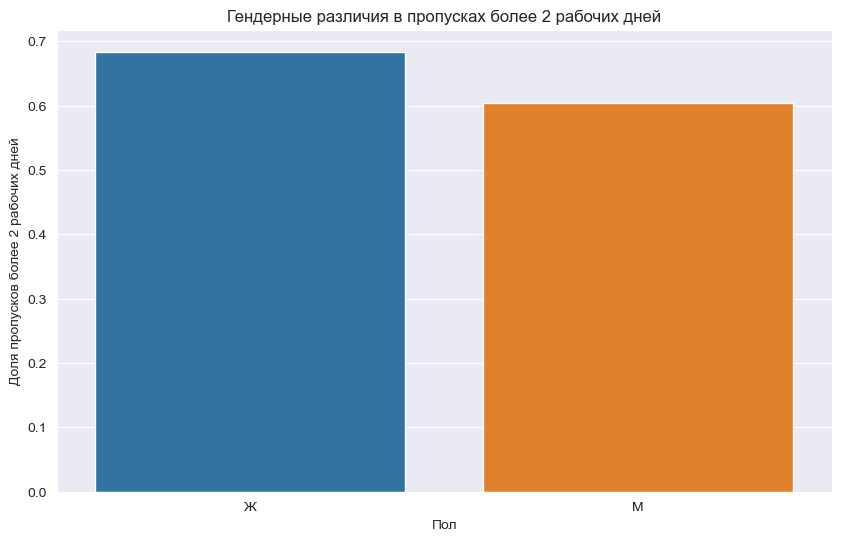

In [18]:
barplot_gender_diff(df, 2)

Из графика видно, что женщины имеют более высокую долю пропусков более 2 рабочих дней по сравнению с мужчинами. Это визуальное представление подтверждает результаты статистического анализа, показывающего значимые гендерные различия в пропусках рабочих дней

### Возрастные различия в пропусках рабочих дней

Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.
* $H_0$: Нет статистически значимых различий в долях сотрудников старше 35 лет и младше или равных 35 годам, пропускающих более 2 рабочих дней в году. 
* $H_1$: Есть статистически значимые различия в долях сотрудников старше 35 лет и младше или равных 35 годам, пропускающих более 2 рабочих дней в году.

Напишем функцию которая будет принимать в себя датафрейм, пороговый возраст, количество дней которые пропустил сотрудник, по ним проводить тест и писать полученное в ходе теста p-value и опровергать или не опровергать нулевую гипотезу

In [19]:
def age_ztest(data, age, work_days, alpha=0.05):
    # Фильтрация и подсчет количества мужчин и женщин, пропускающих более work_days рабочих дней
    df['age_group'] = df['age'].apply(lambda x: 'older' if x > 35 else 'younger_or_equal_35')
    
    count_age = df.groupby('age_group')['more_than_2_days'].sum()
    nobs_age = df['age_group'].value_counts()

    # Выполнение z-теста
    stat_age, p_value = proportions_ztest(count_age, nobs_age)

    print('p-value:', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотизу')
    else:
        print('Не отвергаем нулевую гипотезу')

Проверим наши гипотезы

In [20]:
age_ztest(df, 35, 2)

p-value: 0.9203216442446267
Не отвергаем нулевую гипотезу


Как мы видим p-value довольно большое, и мы не можем отклонить нулевую гипотезу, что указывает на отсутствие возрастных различий. Напишем функцию которая будет показывать гендерные различия в долях пропусков более **works_day** рабочих дней

In [21]:
def barplot_age_diff(df, age, work_days):
    df['age_group'] = df['age'].apply(lambda x: f'older_than_{age}' if x > age else f'{age}_or_younger')

    df['more_than_work_days'] = df['count_sick_days'] > work_days

    plt.figure(figsize=(10, 6))
    sns.barplot(x=df['age_group'], y=df['more_than_work_days'], errorbar=None)

    plt.title(f'Возрастные различия в пропусках более {work_days} рабочих дней')
    plt.xlabel('Возрастная группа')
    plt.ylabel(f'Доля пропусков более {work_days} рабочих дней')
    plt.show()

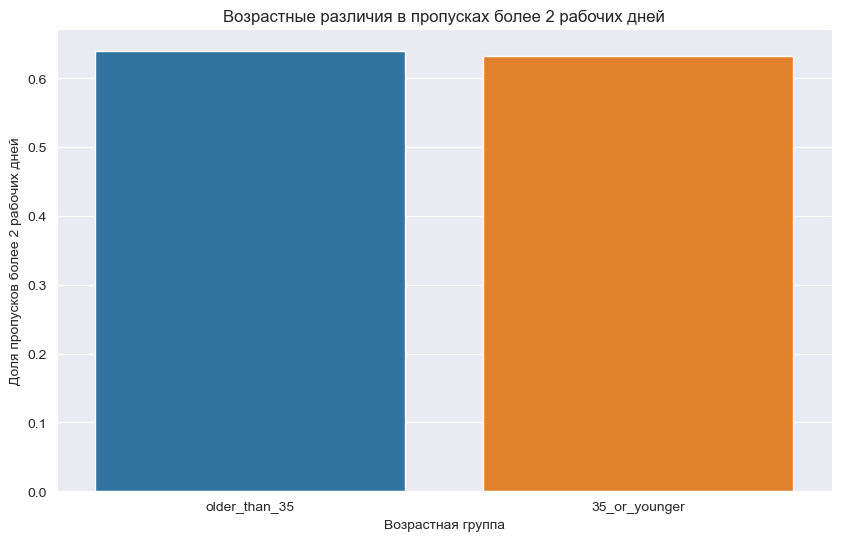

In [22]:
barplot_age_diff(df, 35, 2)

Из графика видно, что различий в долях сотрудников старше 35 лет и младше или равных 35 годам в отношении пропусков более 2 рабочих дней нет.

## Вывод
В рамках данного исследования были проверены две гипотезы, касающиеся пропусков рабочих дней сотрудниками: одна связана с гендерными различиями, а другая - с возрастными. Для анализа использовались данные о количестве больничных дней, возрасте и поле сотрудников.

* Гендерные различия: Наш анализ показал статистически значимые различия между мужчинами и женщинами в долях пропусков более 2 рабочих дней в году. Оказалось, что женщины пропускают более 2 рабочих дней чаще, чем мужчины. Этот результат был подтвержден проведением z-теста для пропорций, где p-значение оказалось значительно ниже установленного порога статистической значимости.!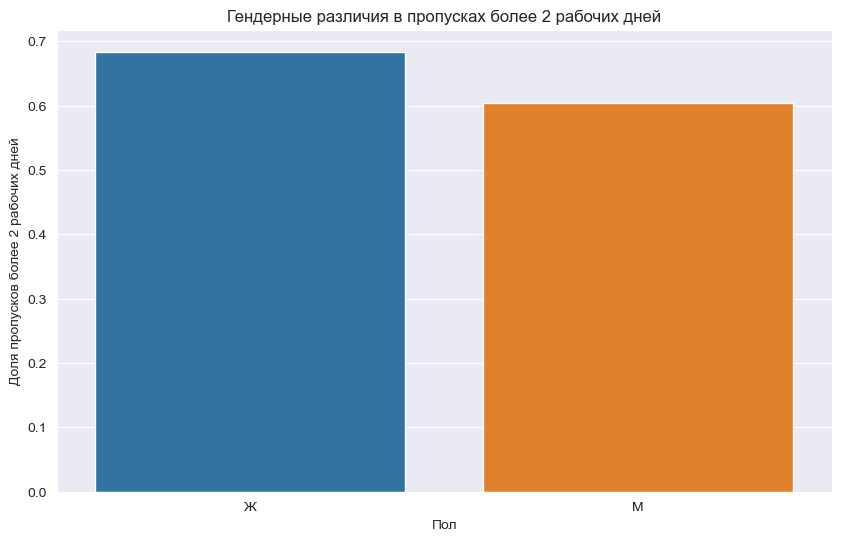

* Возрастные различия: В отношении возрастных различий статистически значимых результатов обнаружено не было. Доля сотрудников, пропускающих более 2 рабочих дней в году, не показала значимого различия между группами старше 35 лет и младше или равными 35 годам. Это указывает на то, что возраст, в данном контексте, не является значимым фактором для пропуска рабочих дней.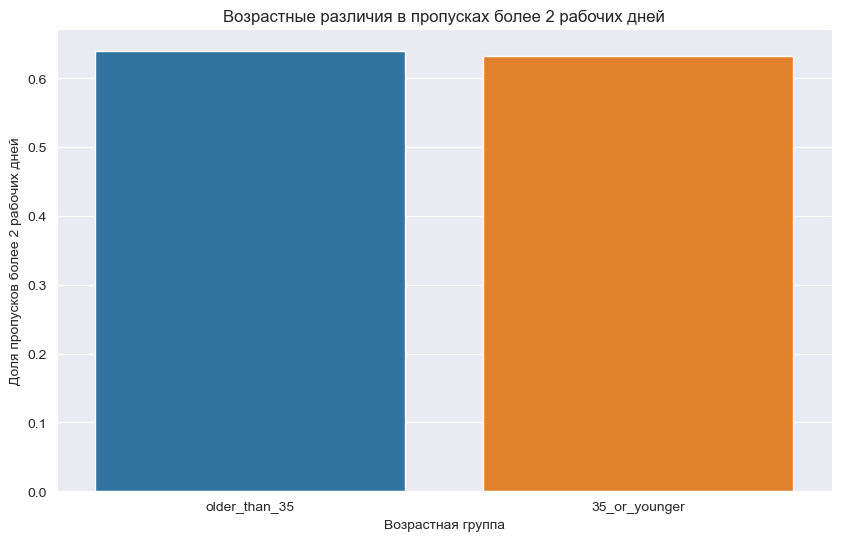

Дополнительно, были проведены визуализации для наглядного представления гендерных и возрастных различий. Визуализации подтвердили выводы, полученные в результате статистического анализа.

Эти результаты могут быть полезны для понимания динамики пропусков рабочих дней среди сотрудников и могут служить основой для разработки мер, направленных на улучшение условий труда и благополучия сотрудников.

